In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
def calculate_bias(CESM_data, AWS_data, season = None):
    i = 0
    bias = list()
    for s in stations:
            #get temperature values for AWS stations
        lat_temp = lats[i]
        lon_temp = lons[i]
        
        AWS_avg = AWS_data.sel(station = s)
        CESM_avg = CESM_data.sel(lat = lat_temp, lon = lon_temp, method = 'nearest')
        
        bias.append(CESM_avg - AWS_avg)
        i = i+1
        
    return bias

In [3]:
# ### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))
cesm_masks = convert_lon(cesm_masks)
cesm_ism = cesm_masks.full_ism.values #full ice sheet
cesm_ism[cesm_ism==0] = np.nan
cesm_ism[cesm_ism>0]=1
cesm_area = cesm_masks.area.values

# # ### ----- Read CESM2 data ----- ###
cesm2_wind = xr.open_dataset('/glade/work/devond/CESM/wind/CESM2_U10_hist.nc')['U10']
cesm2_wind = cesm2_wind.sel(lat = slice(-90,-60), time=slice("1979-01-01", "2015-01-01"))
cesm2_wind = convert_lon(cesm2_wind)

# ### ----- Read CESM1 data ----- ###
cesm1_wind = xr.open_dataset('/glade/work/devond/CESM/wind/CESM1lens_U10_hist.nc')['U10']
cesm1_wind = cesm1_wind.sel(lat = slice(-90,-60), time=slice("1979-01-01", "2015-01-01"))
cesm1_wind = convert_lon(cesm1_wind)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [4]:
cesm2_year_mean = cesm2_wind.groupby(cesm2_wind.time.dt.year).mean()
cesm1_year_mean = cesm1_wind.groupby(cesm1_wind.time.dt.year).mean()

In [5]:
cesm2_map = cesm2_year_mean.mean(dim = 'year')
cesm1_map = cesm1_year_mean.mean(dim = 'year')

cesm_bias_map = cesm2_map.mean(dim = 'ensemble') - cesm1_map.mean(dim = 'ensemble')

In [6]:
cesm2_ts = (cesm2_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)
cesm1_ts = (cesm1_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)

cesm2_ts_mean = cesm2_ts.mean()
cesm2_ts_std = cesm2_ts.std(dim = 'year').mean()
cesm1_ts_mean = cesm1_ts.mean()
cesm1_ts_std = cesm1_ts.std(dim = 'year').mean()

cesm_bias = (cesm2_ts_mean - cesm1_ts_mean).values
uncertainty = np.sqrt((cesm2_ts_std**2 + cesm1_ts_std**2)).values

print(f'CESM2 is {cesm_bias:0.2f} +/- {uncertainty:0.2f} m/s faster than CESM1')

CESM2 is 2.15 +/- 0.07 m/s faster than CESM1


## Observations

In [7]:
AWS_data = xr.load_dataset("/glade/work/devond/AWS/wind_data.nc")
AWS_data = AWS_data.rename_dims({'time':'month'})
stations = AWS_data.station.values
lats = AWS_data.lat.values
lons = AWS_data.lon.values
elevations = AWS_data.elevation.data
AWS_wind = AWS_data['U10']

In [8]:
cesm2_wind_month = (cesm2_wind).groupby(cesm2_wind.time.dt.month).mean() #group by season
cesm2_wind_month['month'] = AWS_wind.sel(station = 'A028').time.values

cesm1_wind_month = (cesm1_wind).groupby(cesm1_wind.time.dt.month).mean() #group by season
cesm1_wind_month['month'] = AWS_wind.sel(station = 'A028').time.values

In [9]:
AWS_bias = calculate_bias(cesm2_wind_month.mean(dim = 'ensemble'), AWS_wind)
AWS_annual_bias = list()
for item in AWS_bias:
    AWS_annual_bias.append(item.mean(dim = 'month'))

In [10]:
cesm1_month_avg= (cesm1_wind_month*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm2_month_avg= (cesm2_wind_month*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm_seasonal_bias = cesm2_month_avg.mean(dim = 'ensemble') - cesm1_month_avg.mean(dim = 'ensemble')

In [11]:
AWS_bias_cesm1 = calculate_bias(cesm1_wind_month.mean(dim = 'ensemble'), AWS_wind)

cesm1_monthly_bias = np.zeros(12)
cesm2_monthly_bias = np.zeros(12)
for i in range(len(AWS_bias)):
    cesm1_monthly_bias = AWS_bias_cesm1[i].values + cesm1_monthly_bias
    cesm2_monthly_bias = AWS_bias[i].values + cesm2_monthly_bias

cesm2_monthly_bias = cesm2_monthly_bias/len(AWS_bias)
cesm1_monthly_bias = cesm1_monthly_bias/len(AWS_bias)

print(f'The average bias of CESM2 is {np.mean(cesm2_monthly_bias):0.2f} m/s')
print(f'The average bias of CESM1 is {np.mean(cesm1_monthly_bias):0.2f} m/s')

The average bias of CESM2 is 0.35 m/s
The average bias of CESM1 is -1.59 m/s


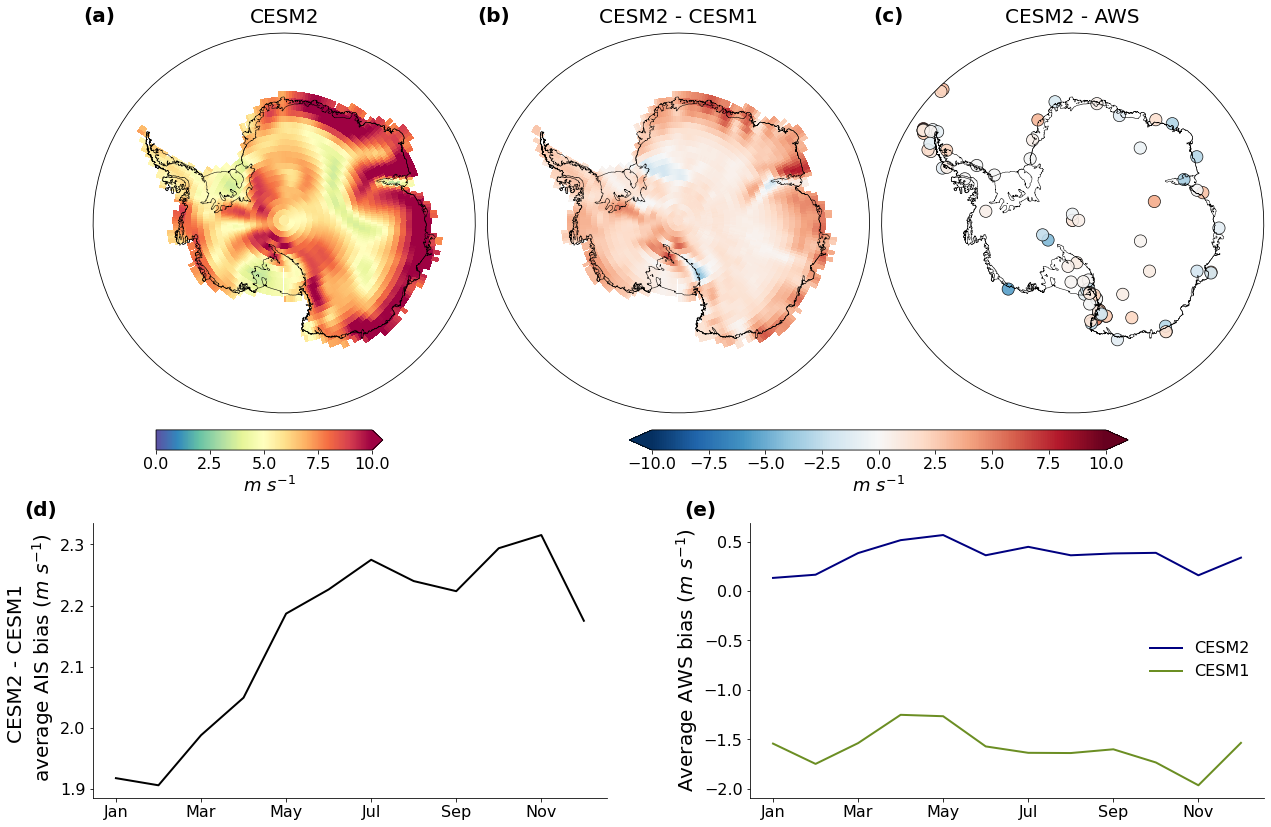

In [13]:
lon = cesm2_map.lon
lat = cesm2_map.lat

fig = plt.figure(figsize = (21, 14))
gs=GridSpec(8,18)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0:4,0:6],projection=crs_sp)
plot_antarctica(ax1,-60)
im1 = ax1.pcolormesh(lon, lat, cesm2_map.mean(dim = 'ensemble')*cesm_ism, transform = crs_ll, cmap = 'Spectral_r',vmin = 0, vmax = 10)
ax1.set_title('CESM2', fontsize = 20)
ax1.text(0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[0:4,6:12],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon, lat, cesm_bias_map*cesm_ism, transform = crs_ll,  cmap = 'RdBu_r', vmin = -10, vmax = 10)
ax2.set_title(f'CESM2 - CESM1', fontsize = 20)
ax2.text(0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[0:4,12:18],projection=crs_sp)
plot_antarctica(ax3,-60)
im3 = ax3.scatter(lons, lats, c = AWS_annual_bias, transform = crs_ll, cmap = 'RdBu_r', vmin = -10, vmax = 10, s = 150, alpha = 0.9, edgecolor = 'black',linewidth=0.7)
ax3.set_title('CESM2 - AWS', fontsize = 20)
ax3.text(0.05, 1.08, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[5:8,0:8])
ax4.plot(cesm_seasonal_bias, color = 'black', linewidth = 2)
ax4.set_xticks([0,2,4,6,8,10])
ax4.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.tick_params(labelsize=16)
ax4.set_ylabel('CESM2 - CESM1 \n average AIS bias ($m~s^{-1}$)', fontsize=20)
ax4.text(-0.07, 1.08, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax5 = plt.subplot(gs[5:8,10:18])
ax5.plot(cesm2_monthly_bias, color = 'navy', linewidth = 2, label = 'CESM2')
ax5.plot(cesm1_monthly_bias, color = 'olivedrab', linewidth = 2, label = 'CESM1')
ax5.set_xticks([0,2,4,6,8,10])
ax5.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax5.spines["right"].set_visible(False)
ax5.spines["top"].set_visible(False)
ax5.tick_params(labelsize=16)
ax5.set_ylabel('Average AWS bias ($m~s^{-1}$)', fontsize=20)
ax5.legend(frameon = False, prop={'size':16})
ax5.text(-0.065, 1.08, '(e)', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


    #fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.48, 0.47, 0.33, 0.02])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label='$m~s^{-1}$', size=18)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.167, 0.47, 0.15, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax, orientation = 'horizontal', extend = 'max')
cb.set_label(label='$m~s^{-1}$', size=18)
cb.ax.tick_params(labelsize=16)

plt.savefig('wind.png', dpi = 300, bbox_inches = 'tight', transparent = 'True')

In [3]:
cesm2_wind = xr.open_dataset('/glade/work/devond/CESM/wind/CESM2_U10_hist.nc')['U10'].mean(dim = 'ensemble')
cesm2_wind = cesm2_wind.sel(time = slice('1979-01-01', '2015-01-01')).sel(lat = slice(-90,-60))
cesm2_wind_lon = convert_lon(cesm2_wind)

cesm1_wind = xr.open_dataset('/glade/work/devond/CESM/wind/CESM1lens_U10_hist.nc')['U10'].mean(dim = 'ensemble')
cesm1_wind = cesm1_wind.sel(time = slice('1979-01-01', '2015-01-01'))
cesm1_wind_lon = convert_lon(cesm1_wind)

## Wind speed vs Observations


In [6]:
cesm2_wind_month = cesm2_wind_lon.groupby(cesm2_wind_lon.time.dt.month).mean() #group by season
cesm2_wind_month['month'] = AWS_wind.sel(station = 'A028').time.values

cesm1_wind_month = cesm1_wind_lon.groupby(cesm1_wind_lon.time.dt.month).mean() #group by season
cesm1_wind_month['month'] = AWS_wind.sel(station = 'A028').time.values

In [7]:
AWS_bias = calculate_bias(cesm2_wind_month, AWS_wind)
AWS_annual_bias = list()
for item in AWS_bias:
    AWS_annual_bias.append(item.mean(dim = 'month').values)

cesm_bias = cesm2_wind_month.mean(dim = 'month') - cesm1_wind_month.mean(dim = 'month')

#get rid of white space for plot
cesm2_map = (cesm2_wind_month.mean(dim = 'month')*cesm_ism).values
cesm2_map, lon2 = add_cyclic_point(cesm2_map, coord=lon)
cesm_bias2, lon2 = add_cyclic_point(cesm_bias, coord=lon)

In [8]:
AWS_annual_wind = list()
for item in AWS_wind.station:
    AWS_annual_wind.append(AWS_wind.sel(station = item).mean(dim = 'month').values)
    
CESM2_relative_bias = np.mean(AWS_annual_bias)/np.mean(AWS_annual_wind)
    
    
AWS_bias_cesm1 = calculate_bias(cesm1_wind_month, AWS_wind)
CESM1_relative_bias =  np.mean(AWS_bias_cesm1)/np.mean(AWS_annual_wind)
    
print(f'CESM1 relative bias = {np.mean(CESM1_relative_bias)*100}%')
print(f'CESM2 relative bias = {np.mean(CESM2_relative_bias)*100}%')

CESM1 relative bias = -22.615912192896094%
CESM2 relative bias = 4.986034615467559%


In [9]:
cesm1_wind_month_avg = (cesm1_wind_month*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm2_wind_month_avg = (cesm2_wind_month*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)


cesm_seasonal_bias = cesm2_wind_month_avg - cesm1_wind_month_avg

In [10]:
AWS_bias_cesm1 = calculate_bias(cesm1_wind_month, AWS_wind)

cesm1_monthly_bias = np.zeros(12)
cesm2_monthly_bias = np.zeros(12)
for i in range(len(AWS_bias)):
    cesm1_monthly_bias = AWS_bias_cesm1[i].values + cesm1_monthly_bias
    cesm2_monthly_bias = AWS_bias[i].values + cesm2_monthly_bias

cesm2_monthly_bias = cesm2_monthly_bias/len(AWS_bias)
cesm1_monthly_bias = cesm1_monthly_bias/len(AWS_bias)

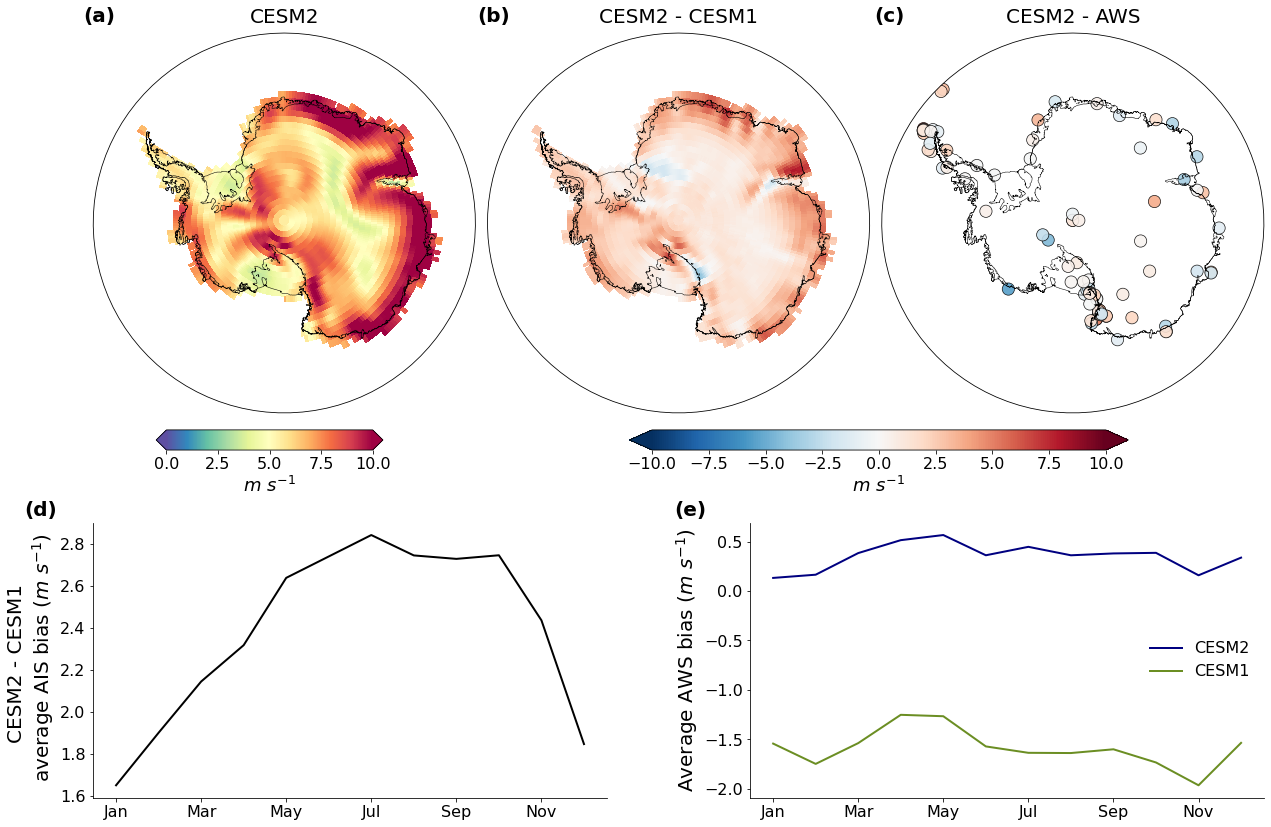

In [11]:
fig = plt.figure(figsize = (21, 14))
gs=GridSpec(8,18)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0:4,0:6],projection=crs_sp)
plot_antarctica(ax1,-60)
im1 = ax1.pcolormesh(lon2, lat, cesm2_map, transform = crs_ll, cmap = 'Spectral_r',vmin = 0, vmax = 10)
ax1.set_title('CESM2', fontsize = 20)
ax1.text(0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[0:4,6:12],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon2, lat, cesm_bias2*cesm_ism2, transform = crs_ll,  cmap = 'RdBu_r', vmin = -10, vmax = 10)
ax2.set_title(f'CESM2 - CESM1', fontsize = 20)
ax2.text(0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[0:4,12:18],projection=crs_sp)
plot_antarctica(ax3,-60)
im3 = ax3.scatter(lons, lats, c = AWS_annual_bias, transform = crs_ll, cmap = 'RdBu_r', vmin = -10, vmax = 10, s = 150, alpha = 0.9, edgecolor = 'black',linewidth=0.7)
ax3.set_title('CESM2 - AWS', fontsize = 20)
ax3.text(0.05, 1.08, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[5:8,0:8])
ax4.plot(cesm_seasonal_bias, color = 'black', linewidth = 2)
ax4.set_xticks([0,2,4,6,8,10])
ax4.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.tick_params(labelsize=16)
ax4.set_ylabel('CESM2 - CESM1 \n average AIS bias ($m~s^{-1}$)', fontsize=20)
ax4.text(-0.07, 1.08, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax5 = plt.subplot(gs[5:8,10:18])
ax5.plot(cesm2_monthly_bias, color = 'navy', linewidth = 2, label = 'CESM2')
ax5.plot(cesm1_monthly_bias, color = 'olivedrab', linewidth = 2, label = 'CESM1')
ax5.set_xticks([0,2,4,6,8,10])
ax5.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax5.spines["right"].set_visible(False)
ax5.spines["top"].set_visible(False)
ax5.tick_params(labelsize=16)
ax5.set_ylabel('Average AWS bias ($m~s^{-1}$)', fontsize=20)
ax5.legend(frameon = False, prop={'size':16})
ax5.text(-0.085, 1.08, '(e)', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


    #fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.48, 0.47, 0.33, 0.02])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label='$m~s^{-1}$', size=18)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.167, 0.47, 0.15, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label='$m~s^{-1}$', size=18)
cb.ax.tick_params(labelsize=16)

plt.savefig('wind.png', dpi = 300, bbox_inches = 'tight', transparent = 'True')

## Wind speed bias by season

In [12]:
def plot_season_bias(lat,lon, cesm_bias, aws_bias, season, ax1, ax2):
    plot_antarctica(ax1,-60)
    im = ax1.pcolormesh(lon, lat, cesm_bias*cesm_ism2, transform = crs_ll,  cmap = 'RdBu_r', vmin = -10, vmax = 10)
    ax1.set_title(f'{season}\n avg. bias = {np.nanmean(cesm_bias*cesm_ism2):0.2f}' + '$^{\circ}$C', fontsize = 20)
    plot_antarctica(ax2,-60)
    ax2.scatter(lons, lats, c = aws_bias, transform = crs_ll, cmap = 'RdBu_r', vmin = -10, vmax = 10, s = 150, alpha = 0.9, edgecolor = 'black',linewidth=0.7)
    return im

In [13]:
AWS_bias_djf, AWS_bias_mam, AWS_bias_son, AWS_bias_jja = list(), list(), list(), list()
for item in AWS_bias:
    AWS_bias_djf.append(item.sel(month=item['month.season']=='DJF').mean(dim = 'month')) 
    AWS_bias_mam.append(item.sel(month=item['month.season']=='MAM').mean(dim = 'month')) 
    AWS_bias_jja.append(item.sel(month=item['month.season']=='JJA').mean(dim = 'month')) 
    AWS_bias_son.append(item.sel(month=item['month.season']=='SON').mean(dim = 'month')) 

cesm_bias_djf = cesm2_wind_month.sel(month=cesm2_wind_month['month.season']=='DJF').mean(dim = 'month') - cesm1_wind_month.sel(month=cesm1_wind_month['month.season']=='DJF').mean(dim = 'month')
cesm_bias_djf, lon2 = add_cyclic_point(cesm_bias_djf, coord=lon)
cesm_bias_mam = cesm2_wind_month.sel(month=cesm2_wind_month['month.season']=='MAM').mean(dim = 'month') - cesm1_wind_month.sel(month=cesm1_wind_month['month.season']=='MAM').mean(dim = 'month')
cesm_bias_mam, lon2 = add_cyclic_point(cesm_bias_mam, coord=lon)
cesm_bias_jja = cesm2_wind_month.sel(month=cesm2_wind_month['month.season']=='JJA').mean(dim = 'month') - cesm1_wind_month.sel(month=cesm1_wind_month['month.season']=='JJA').mean(dim = 'month')
cesm_bias_jja, lon2 = add_cyclic_point(cesm_bias_jja, coord=lon)
cesm_bias_son = cesm2_wind_month.sel(month=cesm2_wind_month['month.season']=='SON').mean(dim = 'month') - cesm1_wind_month.sel(month=cesm1_wind_month['month.season']=='SON').mean(dim = 'month')
cesm_bias_son, lon2 = add_cyclic_point(cesm_bias_son, coord=lon)

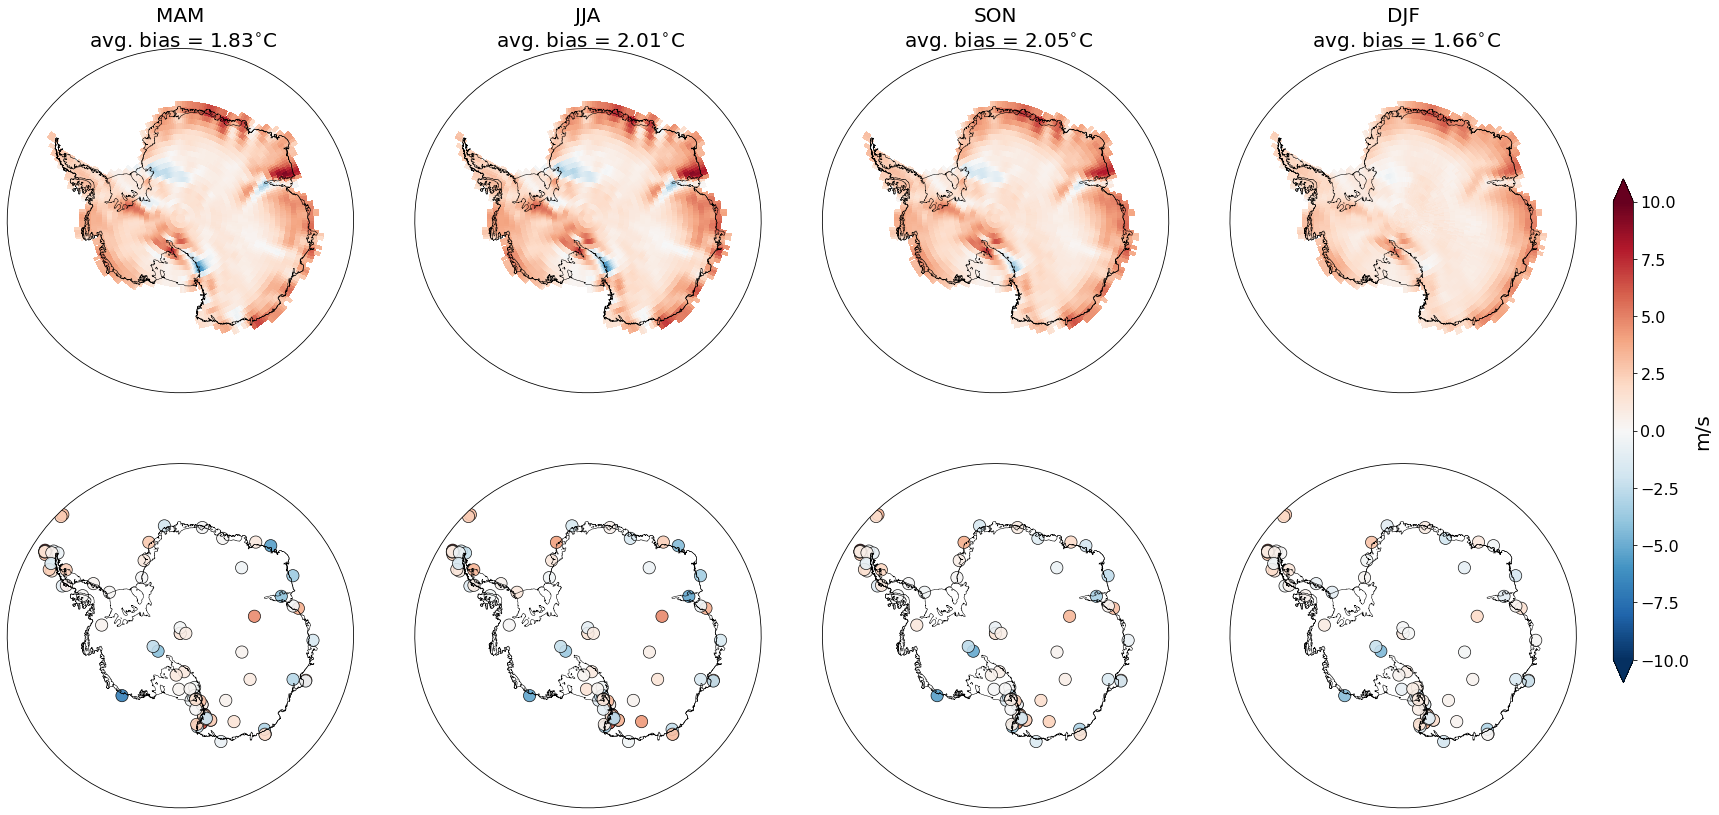

In [14]:
fig = plt.figure(figsize = (28, 14))
gs=GridSpec(2,4)

# MAM
ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax2 = plt.subplot(gs[1,0],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_mam, AWS_bias_mam, 'MAM', ax1, ax2)

# JJA
ax3 = plt.subplot(gs[0,1],projection=crs_sp)
ax4 = plt.subplot(gs[1,1],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_jja, AWS_bias_jja, 'JJA', ax3, ax4)

# SON
ax5 = plt.subplot(gs[0,2],projection=crs_sp)
ax6 = plt.subplot(gs[1,2],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_son, AWS_bias_son, 'SON', ax5, ax6)

# DJF
ax7 = plt.subplot(gs[0,3],projection=crs_sp)
ax8 = plt.subplot(gs[1,3],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_djf, AWS_bias_djf, 'DJF', ax7, ax8)


cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label='m/s', size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig('seasonal_wind_bias.png', dpi = 300)
    